In [10]:
import numpy as np
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import normalize
import os
view_files = {
    "fou": "C:/Users/Chunhe LIU/Desktop/7404p/mfeat-fou",  # 傅里叶系数特征
    "fac": "C:/Users/Chunhe LIU/Desktop/7404p/mfeat-fac",  # 轮廓相关特征
    "kar": "C:/Users/Chunhe LIU/Desktop/7404p/mfeat-kar",  # Karhunen-Loeve 系数特征
    "pix": "C:/Users/Chunhe LIU/Desktop/7404p/mfeat-pix",  # 强度平均特征
    "zer": "C:/Users/Chunhe LIU/Desktop/7404p/mfeat-zer",  # Zernike 矩特征
    "mor": "C:/Users/Chunhe LIU/Desktop/7404p/mfeat-mor",  # 形态学特征
}

# 加载所有视图的数据
views = []
for view_name, file_path in view_files.items():
    views.append(np.loadtxt(file_path))
for idx, view in enumerate(views):
    print(f"View {idx+1} shape:", view.shape)

View 1 shape: (2000, 76)
View 2 shape: (2000, 216)
View 3 shape: (2000, 64)
View 4 shape: (2000, 240)
View 5 shape: (2000, 47)
View 6 shape: (2000, 6)


In [32]:
def construct_laplacian(S):
    """构建拉普拉斯矩阵"""
    D = np.diag(np.sum(S, axis=1))
    L = D - (S + S.T) / 2
    return L

def update_S(Q, beta):
    """更新相似度矩阵 S"""
    n = Q.shape[0]
    S = np.zeros((n, n))
    for j in range(n):
        g_j = np.sum((Q - Q[j])**2, axis=1)
        S[:, j] = np.maximum(-g_j / (2 * beta) + 1 / n, 0)
        S[:, j] /= np.sum(S[:, j])
    return S

def update_Q(L, c):
    """更新特征向量矩阵 Q"""
    eigenvalues, eigenvectors = eigh(L, subset_by_index=[0, c-1])
    Q = eigenvectors[:, :c]
    return Q

def single_view_graph_learning(X, c, beta, max_iter=100):
    """单视图图学习"""
    n = X.shape[0]
    Q = X
    S = update_S(Q, beta)
    
    for _ in range(max_iter):
        L = construct_laplacian(S)
        Q = update_Q(L, c)
        S = update_S(Q, beta)
        
        # 检查收敛条件
        eigenvalues, _ = eigh(L, subset_by_index=[0, c-1])
        if np.sum(eigenvalues) < 1e-6:
            break
    
    return S

In [13]:
def global_graph_learning(S_list, c, gamma, max_iter=100):
    """全局图学习"""
    n = S_list[0].shape[0]
    n_v = len(S_list)
    A = np.mean(S_list, axis=0)
    w = np.ones((n, n_v)) / n_v
    L_0 = construct_laplacian(A)
    P = update_Q(L_0, c)
    
    for _ in range(max_iter):
        for i in range(max_iter):
            # 更新 A
            for j in range(n):
                h_j = np.sum((P - P[j])**2, axis=1)
                a_j = np.maximum(-gamma / 2 * h_j + np.sum([w[j, v] * S_list[v][:, j] for v in range(n_v)], axis=0), 0)
                a_j /= np.sum(a_j)
                A[:, j] = a_j
            
            # 更新 P
            L_A = construct_laplacian(A)
            P = update_Q(L_A, c)
    
            # 检查收敛条件
            eigenvalues, _ = eigh(L_A, subset_by_index=[0, c-1])
            if np.sum(eigenvalues) < 1e-6:
                break
        # 更新 w
        for j in range(n):
            Z_j = np.array([A[:, j] - S_list[v][:, j] for v in range(n_v)]).T
            w[j] = np.linalg.inv(Z_j.T @ Z_j + 1e-6 * np.eye(n_v)) @ np.ones(n_v)  # 添加正则化项
            w[j] /= np.sum(w[j])
    return A

In [22]:
S_views = []
for v in range(len(views)):
    S_v = single_view_graph_learning(X=views[v], c=10, beta=1.0)
    S_views.append(S_v)

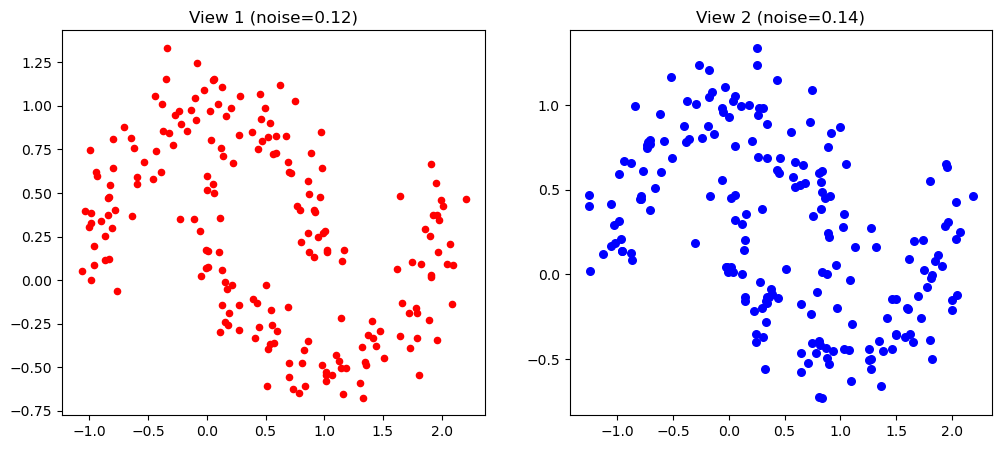

In [23]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

# 生成基础数据
X, labels = make_moons(n_samples=200, noise=0.05, random_state=42)

# 视图1（添加0.12噪声）
np.random.seed(42)
X_view1 = X + 0.12 * np.random.randn(*X.shape)

# 视图2 (噪声更大)
X_view2 = X + 0.14 * np.random.randn(*X.shape)

# 可视化检查
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X_view1[:,0], X_view1[:,1], c= 'red', s=20)
axes[0].set_title('View 1 (noise=0.12)')
axes[1].scatter(X_view2[:, 0], X_view2[:, 1], c= 'blue', s=30)
axes[1].set_title('View 2 (noise=0.14)')
plt.show()

In [28]:
S_view1 = single_view_graph_learning(X_view1, c=2, beta=1.0)
S_view2 = single_view_graph_learning(X_view2, c=2, beta=1.0)

In [29]:
S_views = [S_view1, S_view2]
A = global_graph_learning(S_views, c=2, gamma=1.0, max_iter=50)

print("Global graph shape:", A.shape) # 应为(200, 200)

Global graph shape: (200, 200)


In [30]:
import networkx as nx

def get_labels_from_graph(A, threshold=1e-4):
    adjacency_matrix = (A + A.T) / 2
    adjacency_matrix[adjacency_matrix < threshold] = 0
    adjacency_matrix[adjacency_matrix >= threshold] = 1

    G = nx.from_numpy_array(adjacency_matrix)
    components = list(nx.connected_components(G))

    labels_pred = np.zeros(A.shape[0], dtype=int)
    for cluster_id, comp in enumerate(components):
        labels_idx = list(comp)
        labels_pred[labels_idx] = cluster_id

    return labels_pred

# 获得聚类标签（使用你得到的A）
labels_pred = get_labels_from_graph(A)
print("Predicted labels:", labels_pred)

Predicted labels: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 2 1 2
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]


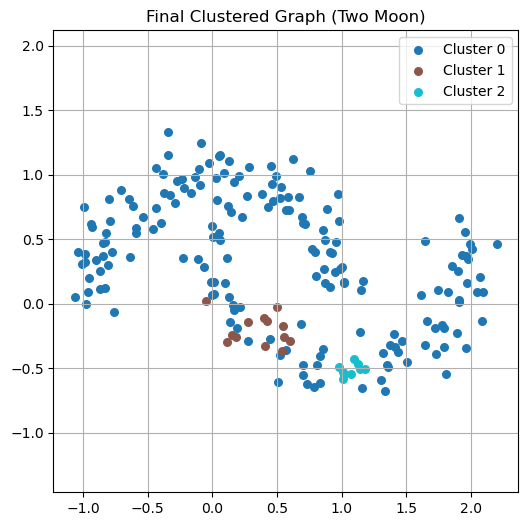

In [31]:
import matplotlib.pyplot as plt

def plot_colored_clusters(X, labels, title='Clustered Graph'):
    plt.figure(figsize=(6,6))
    num_clusters = len(np.unique(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

    for i in range(num_clusters):
        plt.scatter(X[labels==i, 0], X[labels==i, 1], s=30, color=colors[i], label=f'Cluster {i}')

    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

# 例如，使用view1的数据点坐标进行绘制
plot_colored_clusters(X_view1, labels_pred, title='Final Clustered Graph (Two Moon)')

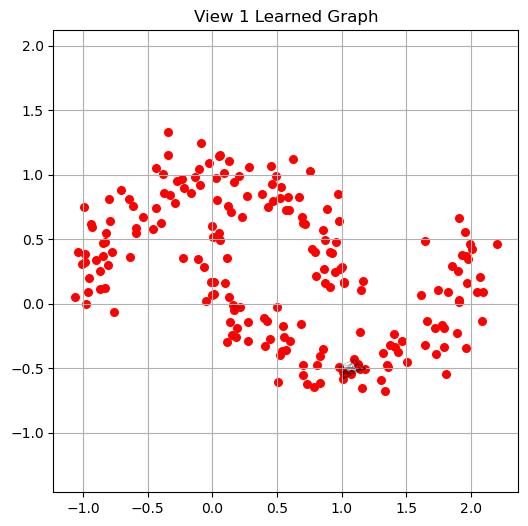

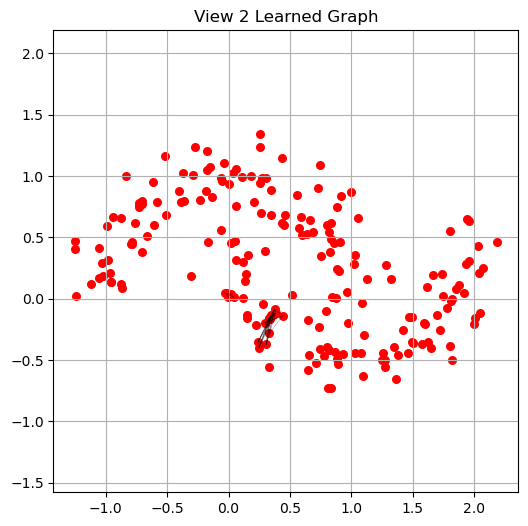

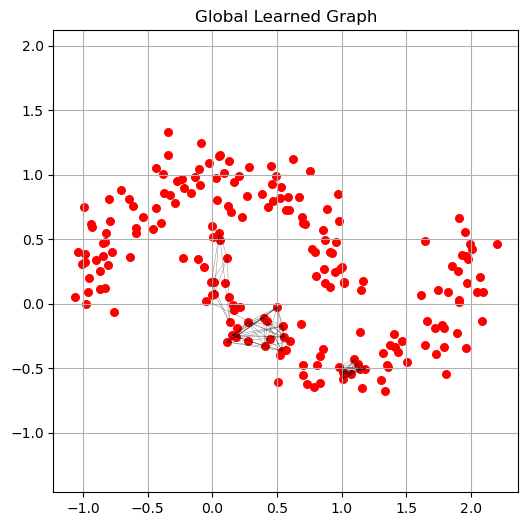

In [21]:
import matplotlib.pyplot as plt

def plot_graph(X, S, title='Graph', threshold=0.02):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c='red', s=30)
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if S[i,j] > threshold or S[j,i] > threshold:
                plt.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], 'k-', linewidth=0.3, alpha=0.5)
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# 视图1 learned graph
plot_graph(X_view1, S_view1, threshold=0.01, title='View 1 Learned Graph')

# 视图2
plot_graph(X_view2, S_view2, threshold=0.01, title='View 2 Learned Graph')

# 全局图用视图1的坐标绘制 (与论文一致)
plot_graph(X_view1, A, threshold=0.02, title='Global Learned Graph')

In [41]:
# Generate two-moon datasets
graph_number = 10
single_view_graph_X = []
for i in range(graph_number):
    X, y = make_moons(n_samples=100, noise=0.05, random_state=i+10)
    single_view_graph_X.append(X)

In [47]:
class_number = 2
S_view0 = single_view_graph_learning(X=single_view_graph_X[0], c=2, beta=1.0)
S_view1 = single_view_graph_learning(X=single_view_graph_X[1], c=2, beta=1.0)
S_view2 = single_view_graph_learning(X=single_view_graph_X[2], c=2, beta=1.0)
S_view3 = single_view_graph_learning(X=single_view_graph_X[3], c=2, beta=1.0)
S_view4 = single_view_graph_learning(X=single_view_graph_X[4], c=2, beta=1.0)
S_view5 = single_view_graph_learning(X=single_view_graph_X[5], c=2, beta=1.0)
S_view6 = single_view_graph_learning(X=single_view_graph_X[6], c=2, beta=1.0)
S_view7 = single_view_graph_learning(X=single_view_graph_X[7], c=2, beta=1.0)
S_view8 = single_view_graph_learning(X=single_view_graph_X[8], c=2, beta=1.0)
S_view9 = single_view_graph_learning(X=single_view_graph_X[9], c=2, beta=1.0)
single_view_graph = [S_view0,S_view1, S_view2, S_view3, S_view4, S_view5, S_view6, S_view7, S_view8, S_view9]
s = [S_view6,S_view8]
global_graph = global_graph_learning(s, c=2, gamma=1.0, max_iter=50)

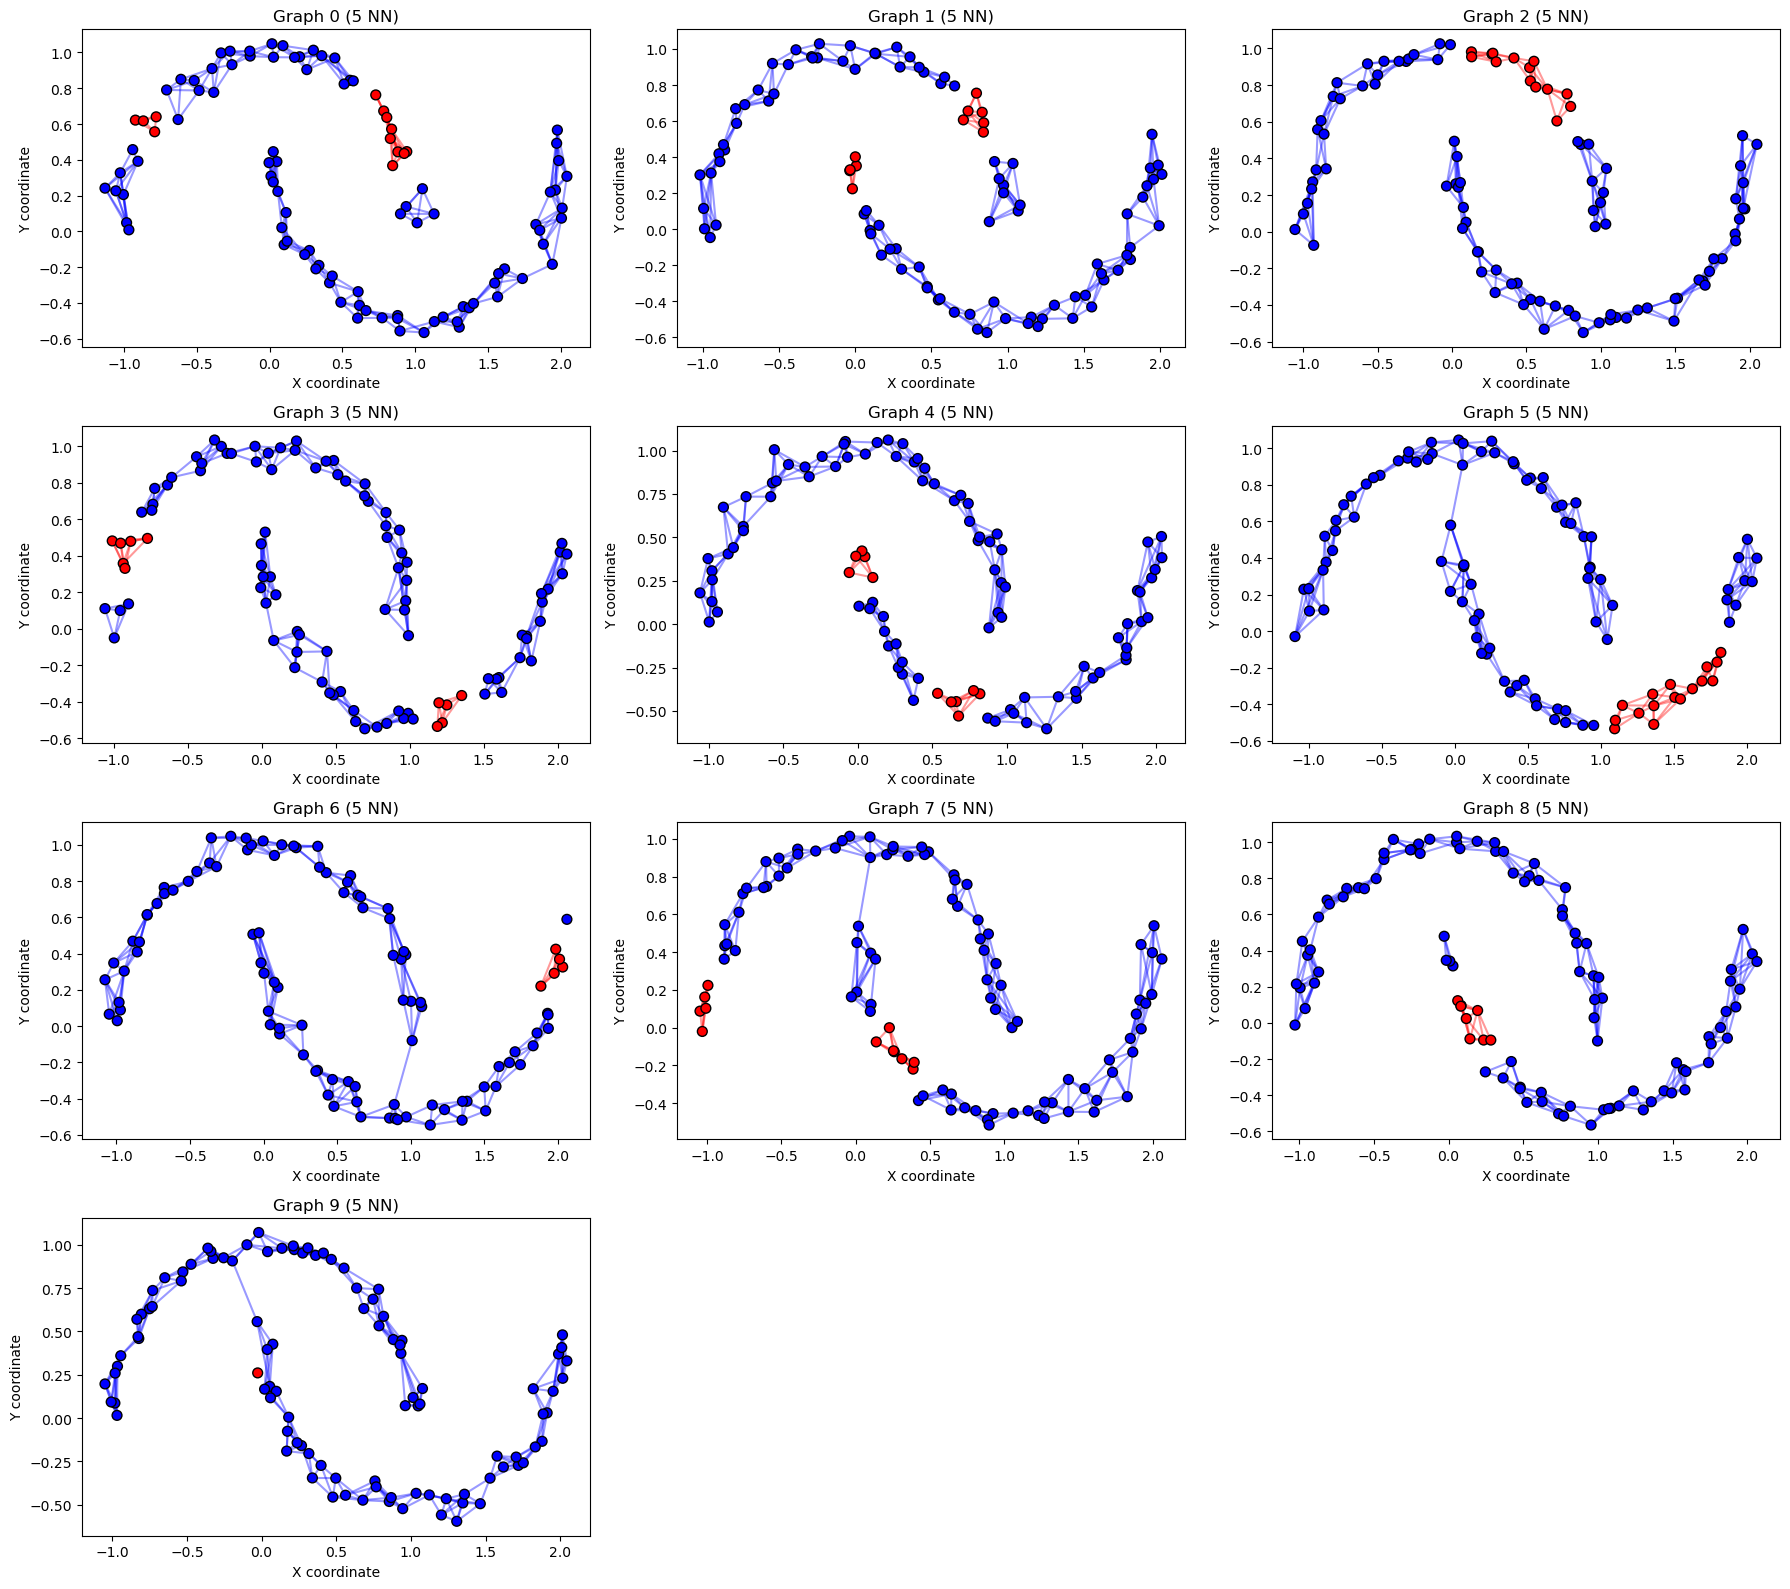

In [48]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


def plot_clusters_multi(X_list, S_list, n_nearest=5):
    # Ensure the input lists are of the same length
    assert len(X_list) == len(S_list), "X_list and S_list must have the same number of elements"
    
    n_datasets = len(X_list)
    rows = int(np.ceil(np.sqrt(n_datasets)))
    cols = int(np.ceil(n_datasets / rows))
    
    plt.figure(figsize=(6 * cols, 4 * rows))
    
    for idx in range(n_datasets):
        X = X_list[idx]
        S = S_list[idx]
        
        # Perform spectral clustering
        model = SpectralClustering(n_clusters=2, affinity='precomputed',
                                   assign_labels='discretize', random_state=42)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", 
                message="Array is not symmetric, and will be converted to symmetric*")
            warnings.filterwarnings("ignore",
                message="Graph is not fully connected, spectral embedding*")
            clusters = model.fit_predict(S)
        
        # Compute nearest neighbor connections
        n = X.shape[0]
        D = np.linalg.norm(X[:, np.newaxis, :] - X, axis=2)
        S_new = np.zeros((n, n), dtype=int)
        for i in range(n):
            nearest_neighbors = np.argsort(D[i])[1:n_nearest+1]
            S_new[i, nearest_neighbors] = 1
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        colors = ['blue', 'red']
        cmap = ListedColormap(colors)
        
        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cmap,
                    edgecolor='k', s=50, zorder=2)
        
        # Plot intra-cluster connections
        for i in range(n):
            for j in range(i + 1, n):
                if (S_new[i, j] or S_new[j, i]) and clusters[i] == clusters[j]:
                    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                             color=colors[clusters[i]], alpha=0.4, zorder=1)
        
        plt.title(f'Graph {idx} ({n_nearest} NN)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

plot_clusters_multi(single_view_graph_X, single_view_graph)

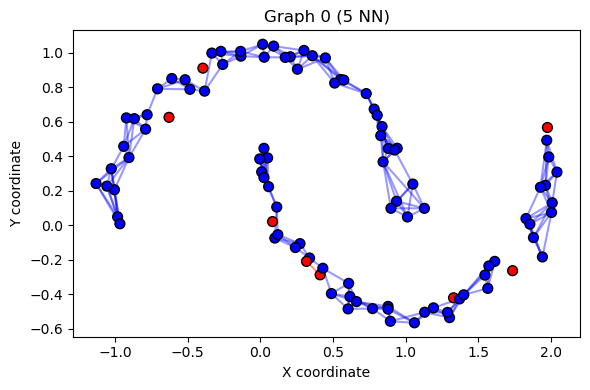

In [49]:
plot_clusters_multi([single_view_graph_X[0]], [global_graph]) # 6 and 8